# DeepTweets : Binary Classification task for tweets

### Outlines
- [1. Packages](#1)
- [2. Preprocessing](#2)
    - [2.1 Data importation](#2.1)
    - [2.2 Data Cleaning](#2.2)
- [3. RNN with Tensorflow](#3)
    - [3.1 Defining global variables](#3.1)
    - [3.2 Training - Validation Split](#3.2)
    - [3.3 Tokenization - Sequences, truncating and padding](#3.3)
    - [3.4 Using pre-defined Embeddings](#3.4)
    - [3.5 Representing the words in vocabulary using the embeddings](#3.5)
    - [3.6 Defining a model](#3.6)
    - [3.7 Defining a Callback](#3.7)
    - [3.8 Plotting training history](#3.8)
    - [3.9 Testing model](#3.9)
- [4. Model comparison](#4)

<a name="1"></a>
### 1. Packages
- [numpy](https://numpy.org/) package for scientific computing.
- [pandas](https://pandas.pydata.org/ ) data analysis and manipulation library.
- [matplotlib](http://matplotlib.org) visualization library.
- [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) TensorFlow is an open source framework to run machine learning, deep learning and other statistical and predictive analytics workloads
- [scikitlearn](https://scikit-learn.org/stable/) machine learning library that supports supervised and unsupervised learning.
- [XGBoost](https://xgboost.readthedocs.io/en/stable/) optimized distributed gradient boosting library.

In [1]:
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy.stats import linregress

<a name="2"></a>
### 2. Preprocessing

<a name="2.1"></a>
#### 2.1. Data importation
In the DeepTweet competition data from [kaggle](https://www.kaggle.com/competitions/deeptweets/data), we loaded The data into Pandas DataFrame objects. This DataFrame contain columns representing various attributes such as TweetId, Label and TweetText.
- **TweetId** : an anonymous id unique to a given tweet
- **Label** : the associated label which is either Sports or Politics
- **TweetText** : the text in a tweet

In [2]:
data = pd.read_csv('data/train.csv', delimiter=',', quotechar='"')
data

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...
...,...,...,...
6520,296675082267410433,Politics,'Photo: PM has laid a wreath at Martyrs Monume...
6521,306677536195231746,Sports,'The secret of the Chennai pitch - crumbling o...
6522,306451295307431937,Sports,@alinabhutto he isn't on Twitter either
6523,306088574221176832,Sports,'Which England player would you take out to di...


<a name="2.2"></a>
#### 2.2 Data Cleaning
The data cleaning process will be divided into several steps :
- Splitting the labels from the training data, then converting the labels 'Sports' and 'Politics' into 0 and 1 respectively ;
- From the training data, we removed the 'TweetId' column because it does not carry any information to our classification problem ;
- Removing stop words ;
- Removing links ;
- Removing hashtags and mentions ;
- Removing punctuations.

In [3]:
def split_x_y(data):
    y = data['Label']
    X = data.drop(columns=['Label'])
    return X, y

X, y = split_x_y(data)

In [4]:
y = y.apply(lambda e : 0 if e == 'Sports' else 1)
y

0       1
1       1
2       0
3       0
4       0
       ..
6520    1
6521    0
6522    0
6523    0
6524    1
Name: Label, Length: 6525, dtype: int64

In [5]:
def remove_stopwords(sentence):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    sentence = sentence.lower()
    words = sentence.split()
    words_no_sw = [w for w in words if w not in stopwords]
    return " ".join(words_no_sw)

In [6]:
def remove_links(sentence):
    return re.sub(r"((https|http)?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", sentence)

In [7]:
def remove_tags(sentence, hatshtags):
    if hatshtags:
        return re.sub(r"(@|#)(\S+)", "", sentence)
    return re.sub(r"(@)(\S+)", "", sentence)

In [8]:
def delete_punc(sentence, hatshtags):
    punctuation = string.punctuation
    if not hatshtags :
        punctuation = punctuation.replace('#', '')
    return "".join([c for c in sentence if c not in punctuation])

In [9]:
def clean_data(X, hatshtags=False):
    # drop the id column
    sentences = X.drop(columns=['TweetId'])
    # removing english stopwords
    sentences['TweetText'] = sentences['TweetText'].apply(remove_stopwords)
    # removing links
    sentences.loc[:, 'TweetText'] = sentences['TweetText'].apply(remove_links)
    # removing tags
    sentences.loc[:, 'TweetText'] = sentences['TweetText'].apply(lambda s : remove_tags(s, hatshtags))
    # removing punctuation
    sentences.loc[:, 'TweetText'] = sentences['TweetText'].apply(lambda s : delete_punc(s, hatshtags))
    return sentences

Since we are using `glove.twitter.27B.100d`, we will keep the hashtags as they can import valuable informations to our model. Therefore we set hashtags parameter to False.

In [10]:
sentences = clean_data(X, hatshtags=False)
sentences.head()

,TweetText
0,#seckerry value measured not dollars terms d...
1,fear so
2,watch video highlights #wwc13 final australia ...
3,rt nitro circus #albertpark #theymakeitlooks...
4,always good thing thanks feedback


<a name="3"></a>
### 3. RNN with Tensorflow

<a name="3.1"></a>
#### 3.1 Defining global variables

Before creating our model, first, we will define some global variables that will be used throughout this section.

- **EMBEDDING_DIM** : Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.
- **MAXLEN** : Maximum length of all sequences. Defaults to 64.
- **TRUNCATIN** : Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.
- **PADDING** : Padding strategy (pad either before or after each sequence.). Defaults to 'post'.
- **OOV_TOKEN** : Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to \"\<OOV>\".
- **TRAINING_SPLIT** : Proportion of data used for training. Defaults to 0.85

In [11]:
EMBEDDING_DIM = 100
MAXLEN = 64
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = 0.85

<a name="3.2"></a>
#### 3.2 Training - Validation Split

In [12]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, y, train_size=TRAINING_SPLIT, random_state=1)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 5546 sentences for training.

There are 5546 labels for training.

There are 979 sentences for validation.

There are 979 labels for validation.


<a name="3.3"></a>
#### 3.3 Tokenization - Sequences, truncating and padding

In [13]:
def fit_tokenizer(train_sentences, oov_token):
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [14]:
tokenizer = fit_tokenizer(train_sentences.TweetText, OOV_TOKEN)

vocab_size = len(tokenizer.word_index)

print(f"there are {vocab_size} in our vocabulary")

there are 11736 in our vocabulary


In [15]:
def seq_pad_trunc(sentences, tokenizer, padding, truncating, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)

    return pad_trunc_sequences

In [16]:
train_pad_trunc_seq = seq_pad_trunc(train_sentences.TweetText, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_trunc(val_sentences.TweetText, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated train sequences shape is : {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences shape is : {val_pad_trunc_seq.shape}\n")

Padded and truncated train sequences shape is : (5546, 64)

Padded and truncated validation sequences shape is : (979, 64)



In [17]:
train_labels = train_labels.to_numpy()
val_labels = val_labels.to_numpy()

<a name="3.4"></a>
#### 3.4 Using pre-defined Embeddings
In our RNN model, we will use word embeddings. For this we will be using pre-trained word vectors. In particular we will be using the 100 dimension version of [GloVe Twitter](https://nlp.stanford.edu/projects/glove/).

In [18]:
glove_file= './data/glove.twitter.27B.100d.txt'

GLOVE_EMBEDDINGS = {}
with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [19]:
test_word = 'and'

test_word_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation shape is {test_word_vector.shape}\n")
print(f"Vector representation of the word \"{test_word}\" : \n{test_word_vector}")

Vector representation shape is (100,)

Vector representation of the word "and" : 
[-1.6697e-01 -3.2589e-01 -1.2003e-02 -1.3198e-01 -1.5361e-01  1.6556e-01
  2.5954e-01  1.3112e-01  1.0092e-02 -4.6486e-01 -2.1164e-01  6.4163e-02
 -6.4094e+00 -2.0224e-01 -8.3826e-03 -5.5104e-01  1.9716e-01 -3.7762e-01
 -5.0864e-01  6.3963e-02 -7.0967e-01  2.2478e-01 -9.5472e-02 -2.5516e-01
 -4.1501e-01 -1.9227e-01 -2.2220e-01  4.3598e-01  4.1871e-01 -1.4593e-03
 -4.6268e-01  1.5682e-01  7.0434e-02 -1.5911e-01 -3.9097e-02 -5.6209e-02
 -1.2356e-01  2.1481e-01  5.1988e-01 -8.1924e-02 -7.3352e-01 -2.7938e-01
 -1.3187e-01  5.8902e-01  4.0815e-01 -4.6319e-01 -2.7336e-02 -3.8121e-01
 -2.0352e-01 -5.2808e-01 -5.8097e-01 -7.5229e-01  9.4600e-02  1.4127e-01
  2.4297e-02 -3.9625e-02  2.2790e-01 -4.5293e-02  3.7604e-01  2.0081e-01
  4.9062e-02  2.0733e-01 -4.1955e-01  3.0427e-01  1.8665e-01  8.1929e-02
 -6.1025e-01 -2.3168e-01 -1.3766e-02  4.3951e-01  4.0073e-01 -2.9532e-01
  1.0936e-01 -9.4972e-02  2.2750e-01  1.97

<a name="3.5"></a>
#### 3.5 Representing the words in vocabulary using the embeddings

First, we save the vector representation of each word in the vocabulary in a numpy array.

- If a word in the vocabulary is not present in **GLOVE_EMBEDDINGS** the representation for that word is left as a column of zeros.
- **word_index** starts counting at 1, because of this you will need to add an extra column at the left-most side of the **EMBEDDINGS_MATRIX** array. This is the reason why we added 1 to **VOCAB_SIZE**.

In [20]:
EMBEDDING_MATRIX = np.zeros((vocab_size + 1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDING_MATRIX[i] = embedding_vector

<a name="3.6"></a>
#### 3.6 Defining a model
Now we define a model that will handle our classification problem while not overfitting.

- The first layer is Embedding layer witch is configured by using pre-trained embeddings.
- Then we used different combinations of layers such as:
    - **LSTM**
    - **Bidirectional(LSTM)**
    - **BatchNormalization**
- The last two layers should be **Dense** layers.
- At last, we Icluded a **Dropout** layer to mitigate overfitting.

In [22]:
model = Sequential([
    Embedding(vocab_size + 1, EMBEDDING_DIM, input_length = MAXLEN, weights = [EMBEDDING_MATRIX], trainable = False),
    Bidirectional(LSTM(96, return_sequences=True)),
    Bidirectional(LSTM(48)),
    BatchNormalization(),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           1173700   
                                                                 
 bidirectional (Bidirectiona  (None, 64, 192)          151296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 96)               92544     
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              99328     
                                                        

<a name="3.7"></a>
#### 3.7 Defining a Callback
For our model training, we are including the following callback :
- **ModelCheckpoint** saves the model with the lowest validation loss during training.

In [27]:
checkpoint_path = 'checkpoint/best_model.h5'
_callbacks   = [
      tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

**Training the model**

In [28]:
history = model.fit(train_pad_trunc_seq,
                    train_labels,
                    epochs=50,
                    validation_data=(val_pad_trunc_seq, val_labels),
                    batch_size=256,
                    callbacks=_callbacks)

Epoch 1/50
22/22 [==============================] - 9s 410ms/step - loss: 0.0240 - accuracy: 0.9912 - val_loss: 0.1796 - val_accuracy: 0.9316
Epoch 2/50
22/22 [==============================] - 8s 359ms/step - loss: 0.0255 - accuracy: 0.9908 - val_loss: 0.1698 - val_accuracy: 0.9305
Epoch 3/50
22/22 [==============================] - 8s 389ms/step - loss: 0.0263 - accuracy: 0.9895 - val_loss: 0.1679 - val_accuracy: 0.9285
Epoch 4/50
22/22 [==============================] - 9s 435ms/step - loss: 0.0278 - accuracy: 0.9908 - val_loss: 0.1682 - val_accuracy: 0.9316
Epoch 5/50
22/22 [==============================] - 9s 397ms/step - loss: 0.0252 - accuracy: 0.9899 - val_loss: 0.1688 - val_accuracy: 0.9326
Epoch 6/50
22/22 [==============================] - 10s 442ms/step - loss: 0.0217 - accuracy: 0.9915 - val_loss: 0.1662 - val_accuracy: 0.9346
Epoch 7/50
22/22 [==============================] - 9s 393ms/step - loss: 0.0185 - accuracy: 0.9935 - val_loss: 0.1734 - val_accuracy: 0.9346
Epoch

<a name="3.8"></a>
#### 3.8 Plotting training history

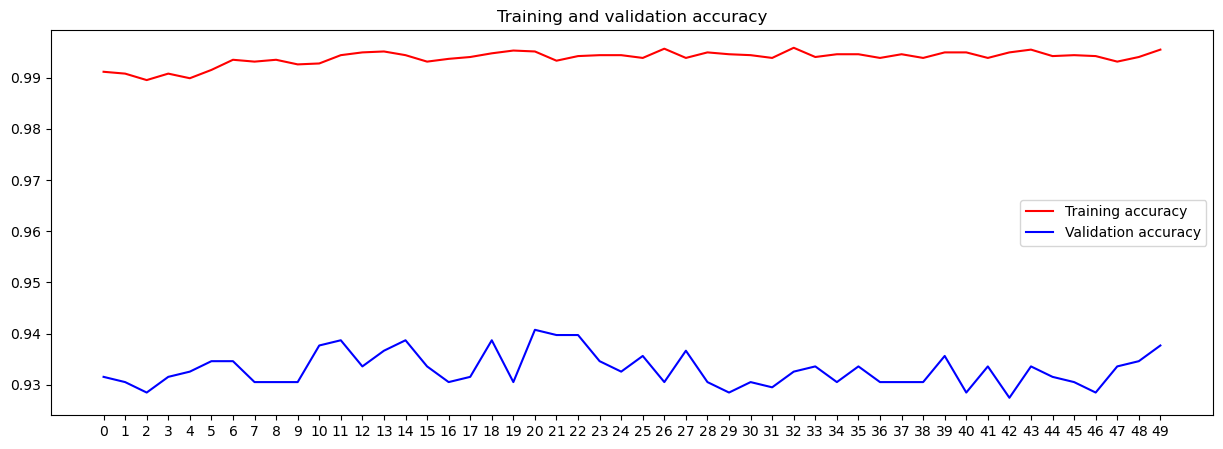

<Figure size 640x480 with 0 Axes>

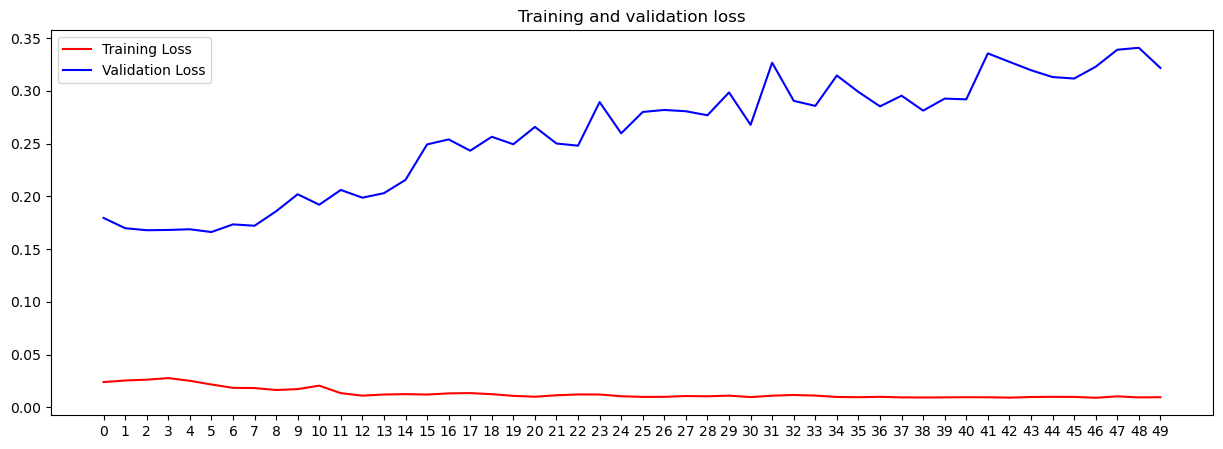

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.figure(figsize=(15,5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xticks(epochs)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.figure(figsize=(15,5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and validation loss')
plt.legend()

plt.show()

<a name="3.9"></a>
#### 3.9 Testing model

In [30]:
test_df = pd.read_csv('data/test.csv', delimiter=',', quotechar='"')
test_cleaned = clean_data(test_df, False)
test_pad_trunc_seq = seq_pad_trunc(test_cleaned.TweetText, tokenizer, PADDING, TRUNCATING, MAXLEN)

In [31]:
model_checkpoint = load_model(checkpoint_path)
predictions = model_checkpoint.predict(test_pad_trunc_seq)
predictions

82/82 [==============================] - 4s 33ms/step


array([[8.312000e-03],
       [9.329885e-01],
       [7.786083e-01],
       ...,
       [5.827473e-04],
       [9.833491e-01],
       [7.256745e-01]], dtype=float32)

In [32]:
submissions = pd.DataFrame({'TweetId': test_df['TweetId'], 'Label' : np.where(predictions.reshape(-1) < 0.5, 'Sports', 'Politics')})
submissions

,TweetId,Label
0,306486520121012224,Sports
1,286353402605228032,Politics
2,289531046037438464,Politics
3,306451661403062273,Politics
4,297941800658812928,Sports
...,...,...
2605,282023761044189184,Sports
2606,303879735006601216,Sports
2607,297956846046703616,Sports
2608,304265049537658880,Politics


In [33]:
submissions.to_csv('./submissions/submission.csv', index=False)

<a name="4"></a>
#### 4. Model comparison
In this section, we will implement various models other than Deep Neural Network to exploit different variations and getting the best model for this classification problem with the best parameters.

The provided models are structured as pipelines that include a TF-IDF (Term Frequency-Inverse Document Frequency) transformation step followed by different classifiers.

For this model comparison, we are using four different models :
- **Multinomial Naive Bayes** (MultinomialNB): Multinomial Naive Bayes is a classification model that is often used in text classification tasks. It's particularly well-suited for dealing with text data where the features (words) are discrete and represent counts, such as term frequencies. It's based on the principle of Bayes' theorem with the "naive" assumption of feature independence.
- **Logistic Regression** (LogisticRegression): Logistic Regression is a simple yet powerful classification model that estimates the probability of a binary outcome.
- **Support Vector Machine** (SVM): Support Vector Machine is a robust classification model that aims to find a hyperplane that maximally separates data points of different classes.
- **XGBoost** (XGBClassifier): XGBoost (Extreme Gradient Boosting) is an ensemble learning method known for its high predictive accuracy and efficiency. It builds an ensemble of decision trees to make predictions.

In [34]:
tfidf = ('TfidfVectorizer', TfidfVectorizer())
models = []
models.append(('MultinomialNB', Pipeline([tfidf, ('MultinomialNB', MultinomialNB())])))
models.append(('LogisticRegression', Pipeline([tfidf, ('LogisticRegression', LogisticRegression())])))
models.append(('SVM', Pipeline([tfidf, ('SVM', SVC())])))
models.append(('XGBoost', Pipeline([tfidf, ('XGBoost', XGBClassifier())])))

In contrary of the previous section, `hatshtags` parameter is set to `True` in order to apply TfidfVectorizer since they do not carry any improvement to it.

In [35]:
cleaned_X = clean_data(X, hatshtags=True)

To evaluate the performance of the various given models, The **cross_val_score** performs **K-Fold** cross-validation of 8 splits with evaluation metric 'accuracy' and returning their accuracy scores. It provides insights into how well each model generalizes to unseen data.

In [36]:
splits = 8
score = 'accuracy'
models_score =[]
for i in models:
    kfold = KFold(n_splits=splits)
    results = cross_val_score(i[1], cleaned_X['TweetText'], y, cv=kfold, scoring=score)
    models_score.append({i[0] : '{} +/- {}'.format(results.mean(), results.std())})
models_score

[{'MultinomialNB': '0.9230638382653675 +/- 0.00920139481489326'},
 {'LogisticRegression': '0.910344678515578 +/- 0.007160885660843905'},
 {'SVM': '0.9216857256706363 +/- 0.007313907435637708'},
 {'XGBoost': '0.8577743444003368 +/- 0.01778745635169117'}]

Performing hyperparameter tuning using a grid search approach with **GridSearchCV** for MultinomialNB (since MultinomialNB scored the highest accuracy), i.e. systematically searching for the best hyperparameter settings to optimize the model's performance on tweets classification problem.

In [37]:
selected_model = models[0][1]

In [38]:
parameters = {
    'TfidfVectorizer__use_idf': (True, False),
    'MultinomialNB__alpha': (2, 1, 1e-1, 1e-2, 1e-3),
}

In [39]:
gs_clf = GridSearchCV(selected_model, parameters, cv=8, n_jobs=-1)

In [40]:
gs_clf.fit(cleaned_X['TweetText'], y)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                                       ('MultinomialNB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'MultinomialNB__alpha': (2, 1, 0.1, 0.01, 0.001),
                         'TfidfVectorizer__use_idf': (True, False)})

In [41]:
gs_clf.best_params_

{'MultinomialNB__alpha': 0.1, 'TfidfVectorizer__use_idf': False}

In [42]:
gs_clf.best_score_

0.9272011833874654

Selecting the model with the best parameters.

In [43]:
best_selected_model = gs_clf.best_estimator_

Making predictions on the cleaned test dataset, then converting them into a DataFrame.

In [44]:
cleaned_test = clean_data(test_df, True)['TweetText']
predictions_mnb = best_selected_model.predict(cleaned_test)
submissions_mnb = pd.DataFrame({'TweetId': test_df['TweetId'], 'Label' : np.where(predictions_mnb.reshape(-1) < 0.5, 'Sports', 'Politics')})
submissions_mnb

,TweetId,Label
0,306486520121012224,Sports
1,286353402605228032,Sports
2,289531046037438464,Politics
3,306451661403062273,Politics
4,297941800658812928,Sports
...,...,...
2605,282023761044189184,Sports
2606,303879735006601216,Sports
2607,297956846046703616,Sports
2608,304265049537658880,Politics


Saving the DataFrame to csv file.

In [45]:
submissions_mnb.to_csv('./submissions/submission_mnb.csv', index=False)